[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/Aplicaciones-Financieras/blob/main/Semana7/2_Hierarchical_Risk_Parity.ipynb)

# Introducción

Critical Line Algorithm (CLA) es un algoritmo para obtener portafolios con mínima varianza sin la necesidad de utilizar programación cuadrática.

Obtenido de 

> David H. Bailey and Marcos Lopez de Prado, "An open-source implementation of the critical line algorithm for portfolio optimization," Algorithms, vol. 6 (2013), pg. 169-196, DOI: 10.3390/a6010169

Se puede encontrar la [publicación](https://ssrn.com/abstract=2197616) y el [código](https://www.davidhbailey.com/dhbpapers/CLA-files.zip) en https://www.davidhbailey.com/dhbpapers/.

In [ ]:
%%writefile CLA.py
#!/usr/bin/env python
# On 20121129
# Critical Line Algorithm
# by MLdP <lopezdeprado@lbl.gov>

import numpy as np
#---------------------------------------------------------------
#---------------------------------------------------------------
class CLA:
    def __init__(self,mean,covar,lB,uB):
        # Initialize the class
        self.mean=mean
        self.covar=covar
        self.lB=lB
        self.uB=uB
        self.w=[] # solution
        self.l=[] # lambdas
        self.g=[] # gammas
        self.f=[] # free weights
#---------------------------------------------------------------
    def solve(self):
        # Compute the turning points,free sets and weights
        f,w=self.initAlgo()
        self.w.append(np.copy(w)) # store solution
        self.l.append(None)
        self.g.append(None)
        self.f.append(f[:])
        while True:
            #1) case a): Bound one free weight
            l_in=None
            if len(f)>1:
                covarF,covarFB,meanF,wB=self.getMatrices(f)
                covarF_inv=np.linalg.inv(covarF)
                j=0
                for i in f:
                    l,bi=self.computeLambda(covarF_inv,covarFB,meanF,wB,j,[self.lB[i],self.uB[i]])
                    if l_in is None or l>l_in:l_in,i_in,bi_in=l,i,bi
                    j+=1
            #2) case b): Free one bounded weight
            l_out=None
            if len(f)<self.mean.shape[0]:
                b=self.getB(f)
                for i in b:
                    covarF,covarFB,meanF,wB=self.getMatrices(f+[i])
                    covarF_inv=np.linalg.inv(covarF)
                    l,bi=self.computeLambda(covarF_inv,covarFB,meanF,wB,meanF.shape[0]-1, \
                        self.w[-1][i])
                    if (self.l[-1]==None or l<self.l[-1]) and (l_out is None or l>l_out):
                        l_out,i_out=l,i                
            #3) decide lambda
            if (l_in==None or l_in<0) and (l_out==None or l_out<0):break
            if l_in is not None and (l_out is None or l_in > l_out):
                self.l.append(l_in)
                f.remove(i_in)
                w[i_in]=bi_in # set value at the correct boundary
            else:
                self.l.append(l_out)
                f.append(i_out)
            #4) compute solution vector
            covarF,covarFB,meanF,wB=self.getMatrices(f)
            covarF_inv=np.linalg.inv(covarF)
            wF,g=self.computeW(covarF_inv,covarFB,meanF,wB)
            for i in range(len(f)):w[f[i]]=wF[i]
            self.w.append(np.copy(w)) # store solution
            self.g.append(g)
            self.f.append(f[:])
            if len(f)==self.mean.shape[0]:
                #5) minimum variance solution
                wF,g=self.computeW(covarF_inv,covarFB,np.zeros(meanF.shape),wB)
                for i in range(len(f)):w[f[i]]=wF[i]
                self.w.append(np.copy(w)) # store solution
                self.g.append(g)
                self.f.append(f[:])
#---------------------------------------------------------------    
    def initAlgo(self):
        # Initialize the algo
        #1) Form structured array
        a=np.zeros((self.mean.shape[0]),dtype=[('id',int),('mu',float)])
        b=[self.mean[i][0] for i in range(self.mean.shape[0])] # dump array into list
        a[:]=list(zip(range(self.mean.shape[0]),b)) # fill structured array
        #2) Sort structured array
        b=np.sort(a,order='mu')
        #3) First free weight
        i,w=b.shape[0],np.copy(self.lB)
        while sum(w)<1:
            i-=1
            w[b[i][0]]=self.uB[b[i][0]]
        w[b[i][0]]+=1-sum(w)
        return [b[i][0]],w
#---------------------------------------------------------------    
    def computeBi(self,c,bi):
        if c>0:
            bi=bi[1]
        if c<0:
            bi=bi[0]
        return bi
#---------------------------------------------------------------
    def computeW(self,covarF_inv,covarFB,meanF,wB):
        #1) compute gamma
        onesF=np.ones(meanF.shape)
        g1=np.dot(np.dot(onesF.T,covarF_inv),meanF)
        g2=np.dot(np.dot(onesF.T,covarF_inv),onesF)
        if np.all(wB)==None:
            g,w1=float(-self.l[-1]*g1/g2+1/g2),0
        else:
            onesB=np.ones(wB.shape)
            g3=np.dot(onesB.T,wB)
            g4=np.dot(covarF_inv,covarFB)
            w1=np.dot(g4,wB)
            g4=np.dot(onesF.T,w1)
            g=float(-self.l[-1]*g1/g2+(1-g3+g4)/g2)
        #2) compute weights
        w2=np.dot(covarF_inv,onesF)
        w3=np.dot(covarF_inv,meanF)
        return -w1+g*w2+self.l[-1]*w3,g
#---------------------------------------------------------------
    def computeLambda(self,covarF_inv,covarFB,meanF,wB,i,bi):
        #1) C
        onesF=np.ones(meanF.shape)
        c1=np.dot(np.dot(onesF.T,covarF_inv),onesF)
        c2=np.dot(covarF_inv,meanF)
        c3=np.dot(np.dot(onesF.T,covarF_inv),meanF)
        c4=np.dot(covarF_inv,onesF)
        c=-c1*c2[i]+c3*c4[i]
        if c==0:return
        #2) bi
        if type(bi)==list:bi=self.computeBi(c,bi)
        #3) Lambda
        if np.all(wB==None):
            # All free assets
            return float((c4[i]-c1*bi)/c),bi
        else:
            onesB=np.ones(wB.shape)
            l1=np.dot(onesB.T,wB)
            l2=np.dot(covarF_inv,covarFB)
            l3=np.dot(l2,wB)
            l2=np.dot(onesF.T,l3)
            return float(((1-l1+l2)*c4[i]-c1*(bi+l3[i]))/c),bi
#---------------------------------------------------------------
    def getMatrices(self,f):
        # Slice covarF,covarFB,covarB,meanF,meanB,wF,wB
        covarF=self.reduceMatrix(self.covar,f,f)
        meanF=self.reduceMatrix(self.mean,f,[0])
        b=self.getB(f)
        covarFB=self.reduceMatrix(self.covar,f,b)
        wB=self.reduceMatrix(self.w[-1],b,[0])
        return covarF,covarFB,meanF,wB
#---------------------------------------------------------------
    def getB(self,f):
        return self.diffLists(range(self.mean.shape[0]),f)
#---------------------------------------------------------------
    def diffLists(self,list1,list2):
        return list(set(list1)-set(list2))
#---------------------------------------------------------------
    def reduceMatrix(self,matrix,listX,listY):
        matrix = np.array(matrix)
        # Reduce a matrix to the provided list of rows and columns
        if len(listX)==0 or len(listY)==0:return
        matrix_=matrix[:,listY[0]:listY[0]+1]
        for i in listY[1:]:
            a=matrix[:,i:i+1]
            matrix_=np.append(matrix_,a,1)
        matrix__=matrix_[listX[0]:listX[0]+1,:]
        for i in listX[1:]:
            a=matrix_[i:i+1,:]
            matrix__=np.append(matrix__,a,0)
        return matrix__
#---------------------------------------------------------------
    def getMinVar(self):
        # Get the minimum variance solution
        var=[]
        for w in self.w:
            a=np.dot(np.dot(w.T,self.covar),w)
            var.append(a)
        return min(var)**.5,self.w[var.index(min(var))]
#---------------------------------------------------------------
    def getMaxSR(self):
        # Get the max Sharpe ratio portfolio
        #1) Compute the local max SR portfolio between any two neighbor turning points
        w_sr,sr=[],[]
        for i in range(len(self.w)-1):
            w0=np.copy(self.w[i])
            w1=np.copy(self.w[i+1])
            kargs={'minimum':False,'args':(w0,w1)}
            a,b=self.goldenSection(self.evalSR,0,1,**kargs)
            w_sr.append(a*w0+(1-a)*w1)
            sr.append(b)
        return max(sr),w_sr[sr.index(max(sr))]
#---------------------------------------------------------------
    def evalSR(self,a,w0,w1):
        # Evaluate SR of the portfolio within the convex combination
        w=a*w0+(1-a)*w1
        b=np.dot(w.T,self.mean)[0,0]
        c=np.dot(np.dot(w.T,self.covar),w)[0,0]**.5
        return b/c
#---------------------------------------------------------------
    def goldenSection(self,obj,a,b,**kargs):
        # Golden section method. Maximum if kargs['minimum']==False is passed 
        from math import log,ceil
        tol,sign,args=1.0e-9,1,None
        if 'minimum' in kargs and kargs['minimum']==False:sign=-1
        if 'args' in kargs:args=kargs['args']
        numIter=int(ceil(-2.078087*log(tol/abs(b-a))))
        r=0.618033989
        c=1.0-r
        # Initialize
        x1=r*a+c*b;x2=c*a+r*b
        f1=sign*obj(x1,*args);f2=sign*obj(x2,*args)
        # Loop
        for i in range(numIter):
            if f1>f2:
                a=x1
                x1=x2;f1=f2
                x2=c*a+r*b;f2=sign*obj(x2,*args)
            else:
                b=x2
                x2=x1;f2=f1
                x1=r*a+c*b;f1=sign*obj(x1,*args)
        if f1<f2:return x1,sign*f1
        else:return x2,sign*f2
#---------------------------------------------------------------
    def efFrontier(self,points):
        # Get the efficient frontier
        mu,sigma,weights=[],[],[]
        a=np.linspace(0,1,points/len(self.w))[:-1] # remove the 1, to avoid duplications
        b=range(len(self.w)-1)
        for i in b:
            w0,w1=self.w[i],self.w[i+1]
            if i==b[-1]:a=np.linspace(0,1,points/len(self.w)) # include the 1 in the last iteration
            for j in a:
                w=w1*j+(1-j)*w0
                weights.append(np.copy(w))
                mu.append(np.dot(w.T,self.mean)[0,0])
                sigma.append(np.dot(np.dot(w.T,self.covar),w)[0,0]**.5)
        return mu,sigma,weights
#---------------------------------------------------------------
#---------------------------------------------------------------

Writing CLA.py


# Dependencia

In [ ]:
!pip install -U scipy yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 81.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 14.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: htm

In [ ]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

import random
import numpy as np
import pandas as pd

import yfinance as yf

from scipy.spatial.distance import squareform

from CLA import CLA

# Bases de HRP

El algoritmo consta de 3 grandes pasos:

- Hierarchical Tree Clustering

- Matrix Seriation

- Recursive Bisection

# Funciones

La siguiente función nos crea un portafolio en que los pesos asignados a cada activo se toman como valores inversos a sus varianzas (inversiones mas seguras)

In [ ]:
def getIVP(cov,**kargs):
    # Compute the inverse-variance portfolio
    ivp = 1./np.diag(cov)
    ivp /= ivp.sum()
    return ivp

In [ ]:
def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_ = cov.loc[cItems,cItems] # matrix slice
    w_ = getIVP(cov_).reshape(-1,1)
    cVar = np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

La siguiente función sirve para reorganizar las filas y las columnas de la matriz de covarianzas para que los valores más grandes se queden alrededos de la diagonal. Esta tiene un propiedad útil: Inversiones similares son posicionadas juntas y distintos son puestos lejos unos de otros.

In [ ]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1,0],link[-1,1]])
    numItems = link[-1,3] # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0,sortIx.shape[0]*2,2) # make space
        df0 = sortIx[sortIx >= numItems] # find clusters
        i = df0.index;j = df0.values-numItems
        sortIx[i] = link[j,0] # item 1
        df0 = pd.Series(link[j,1],index = i+1)
        sortIx = sortIx.append(df0) # item 2
        sortIx = sortIx.sort_index() # re-sort
        sortIx.index = range(sortIx.shape[0]) # re-index
    return sortIx.tolist()

La siguiente función regresa los pesos del portafolio de acuerdo al agoritmo de HRP:

Para crear los pesos, se usa la "inverse-variance allocation", el algoritmo es el siguiente:

1. El algoritmo se inicializa:
  
  a. Creando una lista de objetos: $L = \left\{ L_0 \right\}$ con $L_0 = \left\{ n\right\}_{n=1, \dots, N}$

  b. Asignando un peso unitario a todos los objetos: $w_n = 1$, $\forall n = 1, \dots, N$

2. Si $\|L_i\| = 1$, $\forall L_i \in L$ detenerse.
3. Para cada $L_i \in L$ tal que $\|L_i\| > 1$:

  a. bisectar $L_i$ en dos subconjuntos, $L_i^{(1)} \cup L_i^{(2)} = L_i$, donde $\|L_i^{(1)}\| = int\left[ \frac{1}{2}\|L_i\| \right]$, y el orden es preservado

  b. define la varianza de $L_i^{(j)}$, $j = 1, 2$ como la forma cuadrática $\tilde{V}_i^{(j)} \equiv \tilde{w}_i^{(j)^{T}} V_i^{(j)} \tilde{w}_i^{(j)}$, donde $V_i^{(j)}$ es la matriz de covarianza entre los que conforman la bisección $L_i^{(j)}$, y $\tilde{w}_i^{(j)} = diag\left[ V_i^{(j)}\right] ^ {-1} \frac{1}{tr\left[ diag\left[ V_i^{(j)}\right] \right]}$, donde $diag\left[ . \right]$ y $tr \left[ . \right]$ son los operadores diagonal y traza.
  
  c. Calcula el factor de división: $\alpha_i = 1 - \frac{\tilde{V}_i^{(1)}}{\tilde{V}_i^{(1)}+\tilde{V}_i^{(2)}}$, tal que $0 \leq \alpha_i \leq 1$

  d. re-escala los pesos por un factor de $\alpha_i$, $\forall n \in L_i^{(1)}$

  re-escala los pesos por un factor de $\left(1 - \alpha_i \right)$, $\forall n \in L_i^{(2)}$

4. Repite desde el paso 2.

In [ ]:
def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1,index = sortIx)
    cItems = [sortIx] # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [
                  i[j:k] 
                  for i in cItems 
                  for j, k in ((0, int(len(i)/2)), (int(len(i)/2), len(i))) 
                  if len(i) > 1
        ] # bi-section
        for i in range(0,len(cItems),2): # parse in pairs
            cItems0 = cItems[i] # cluster 1
            cItems1 = cItems[i+1] # cluster 2
            cVar0 = getClusterVar(cov,cItems0)
            cVar1 = getClusterVar(cov,cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha # weight 1
            w[cItems1] *= 1-alpha # weight 2
    return w

In [ ]:
def getCLA(cov,**kargs):
    # Compute CLA's minimum variance portfolio
    mean = np.arange(cov.shape[0]).reshape(-1,1) # Not used by C portf
    lB = np.zeros(mean.shape)
    uB = np.ones(mean.shape)
    cla = CLA(mean,cov,lB,uB)
    cla.solve()
    return cla.w[-1].flatten()

In [ ]:
def correlDist(corr):
    # A distance matrix based on correlation, where 0< = d[i,j]< = 1
    # This is a proper distance metric
    dist = ((1-corr)/2.)**.5 # distance matrix
    return squareform(dist)

In [ ]:
def plotCorrMatrix(path,corr,labels = None):
    # Heatmap of the correlation matrix
    if labels is None:labels = []
    plt.pcolor(corr)
    plt.colorbar()
    plt.yticks(np.arange(.5,corr.shape[0]+.5),labels)
    plt.xticks(np.arange(.5,corr.shape[0]+.5),labels)
    plt.savefig(path)
    plt.clf();plt.close() # reset pylab
    return

In [ ]:
def get_allocations(x, return_linkage = False):
    #1) Load the data
    cov, corr = x.cov(), x.corr()
    #2) compute and plot correl matrix
    plotCorrMatrix('HRP3_corr0.png',corr,labels = corr.columns)
    #3) cluster
    dist = correlDist(corr)
    link = sch.linkage(dist,'single')
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist() # recover labels
    df0 = corr.loc[sortIx,sortIx] # reorder
    plotCorrMatrix('HRP3_corr1.png',df0,labels = df0.columns)
    #4) Capital allocation
    hrp = getRecBipart(cov,sortIx)
    allocation = hrp.to_frame(name = 'HRP').sort_index()
    allocation['CLA'] = np.round(getCLA(cov), 6)
    if return_linkage:
        return allocation, link
    return allocation

# Datos

Utilizaremos las acciones de diversas compañias especializadas en tecologías relacionada a informática: Apple, IBM, Microsoft, Palantir Tech, Fastly, CloudFlare, Datadog, Zscaler, Snowflake.

In [ ]:
data = yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        # tickers = "GOOG AAPL IBM MSFT FB NFLX AMZN PLTR FSLY NET DDOG ZS SNOW",
        tickers = "AAPL IBM MSFT PLTR FSLY NET DDOG ZS SNOW NFLX AMZN",

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "1y",

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1d",

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        # group_by = 'ticker',
    ).loc[:, 'Adj Close'].dropna()
data

[*********************100%***********************]  11 of 11 completed


,AAPL,AMZN,DDOG,FSLY,IBM,MSFT,NET,NFLX,PLTR,SNOW,ZS
Date,,,,,,,,,,,
2022-01-27 00:00:00-05:00,158.301254,139.637497,128.149994,24.469999,126.258270,297.056519,80.339996,386.700012,12.28,244.720001,223.080002
2022-01-28 00:00:00-05:00,169.347153,143.977997,136.960007,25.049999,128.144699,305.398407,84.180000,384.359985,12.71,253.520004,238.699997
2022-01-31 00:00:00-05:00,173.771469,149.573502,146.110001,28.660000,127.258667,308.093109,96.400002,427.140015,13.71,275.899994,257.109985
2022-02-01 00:00:00-05:00,173.602448,151.193497,147.779999,29.200001,129.126038,305.893738,102.430000,457.130005,14.20,283.760010,261.089996
2022-02-02 00:00:00-05:00,174.825348,150.612503,142.199997,27.379999,130.764755,310.550079,99.800003,429.480011,13.32,268.279999,257.500000
...,...,...,...,...,...,...,...,...,...,...,...
2023-01-20 00:00:00-05:00,137.869995,97.250000,71.050003,10.240000,141.199997,240.220001,45.599998,342.500000,7.02,144.820007,117.120003
2023-01-23 00:00:00-05:00,141.110001,97.519997,75.290001,10.620000,141.860001,242.580002,47.619999,357.420013,7.38,150.300003,123.760002
2023-01-24 00:00:00-05:00,142.529999,96.320000,73.690002,10.250000,141.490005,242.039993,46.669998,363.829987,7.02,145.789993,122.650002


# Rendimientos

In [ ]:
x = np.log(data.iloc[:-20,:] / data.iloc[:-20,:].shift()) / (1 / 252) # Para anualizar los retornos
x.dropna(inplace = True)
x

,AAPL,AMZN,DDOG,FSLY,IBM,MSFT,NET,NFLX,PLTR,SNOW,ZS
Date,,,,,,,,,,,
2022-01-28 00:00:00-05:00,16.997621,7.713904,16.754864,5.903339,3.737290,6.979079,11.765825,-1.529553,8.673131,8.902663,17.054619
2022-01-31 00:00:00-05:00,6.499149,9.608113,16.297043,33.926412,-1.748458,2.213785,34.158310,26.594136,19.085575,21.318123,18.722701
2022-02-01 00:00:00-05:00,-0.245231,2.714678,2.863956,4.703912,3.670934,-1.805394,15.289703,17.099703,8.849347,7.078777,3.871025
2022-02-02 00:00:00-05:00,1.768930,-0.970230,-9.699525,-16.217698,3.177968,3.807064,-6.554880,-15.722941,-16.121778,-14.136605,-3.489051
2022-02-03 00:00:00-05:00,-4.248996,-20.499821,-7.518637,-17.333614,0.971274,-10.012279,-8.056064,-14.416349,-17.021601,-11.551331,-12.519325
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-20 00:00:00-05:00,-0.133283,0.799966,-0.232058,-4.160482,4.335791,1.410897,7.925520,-0.096155,-1.592421,5.612062,2.834635
2022-12-21 00:00:00-05:00,5.929674,4.630958,3.916222,2.088813,1.529326,2.726133,0.000000,8.401485,7.475960,9.697531,-1.714832
2022-12-22 00:00:00-05:00,-6.063056,-8.806700,-14.171604,-11.553264,-2.243804,-6.516784,-6.531557,-0.177663,-7.076901,-11.201072,-7.737690


In [ ]:
x_prueba = data.iloc[-20:, :].copy()
x_prueba

,AAPL,AMZN,DDOG,FSLY,IBM,MSFT,NET,NFLX,PLTR,SNOW,ZS
Date,,,,,,,,,,,
2022-12-28 00:00:00-05:00,126.040001,81.820000,69.839996,7.45,140.020004,234.529999,42.220001,276.880005,6.07,138.419998,107.860001
2022-12-29 00:00:00-05:00,129.610001,84.180000,73.940002,8.15,141.059998,241.009995,45.360001,291.119995,6.40,142.380005,111.870003
2022-12-30 00:00:00-05:00,129.929993,84.000000,73.500000,8.19,140.889999,239.820007,45.209999,294.880005,6.42,143.539993,111.900002
2023-01-03 00:00:00-05:00,125.070000,85.820000,72.089996,8.08,141.550003,239.580002,43.020000,294.950012,6.39,135.500000,110.190002
2023-01-04 00:00:00-05:00,126.360001,85.139999,68.959999,8.42,142.600006,229.100006,43.049999,309.410004,6.58,130.440002,111.589996
2023-01-05 00:00:00-05:00,125.019997,83.120003,63.500000,8.24,141.110001,222.309998,38.910000,309.700012,6.32,121.559998,104.389999
2023-01-06 00:00:00-05:00,129.619995,86.080002,64.139999,8.48,143.699997,224.929993,39.900002,315.549988,6.40,124.059998,103.959999
2023-01-09 00:00:00-05:00,130.149994,87.360001,65.940002,8.82,143.550003,227.119995,40.400002,315.170013,6.50,134.429993,104.750000
2023-01-10 00:00:00-05:00,130.729996,89.870003,66.769997,8.86,144.800003,228.850006,41.799999,327.540009,6.70,137.940002,104.970001


In [ ]:
ganancia_mes_final =  x_prueba.iloc[-1,:] / x_prueba.iloc[1,:]
ganancia_mes_final

AAPL    1.110717
AMZN    1.178665
DDOG    1.027860
FSLY    1.261350
IBM     0.953141
MSFT    1.029003
NET     1.091711
NFLX    1.253332
PLTR    1.131250
SNOW    1.070726
ZS      1.119067
dtype: float64

# Portafolios

{'icoord': [[35.0, 35.0, 45.0, 45.0],
  [25.0, 25.0, 40.0, 40.0],
  [95.0, 95.0, 105.0, 105.0],
  [85.0, 85.0, 100.0, 100.0],
  [75.0, 75.0, 92.5, 92.5],
  [65.0, 65.0, 83.75, 83.75],
  [55.0, 55.0, 74.375, 74.375],
  [32.5, 32.5, 64.6875, 64.6875],
  [15.0, 15.0, 48.59375, 48.59375],
  [5.0, 5.0, 31.796875, 31.796875]],
 'dcoord': [[0.0, 0.2904962912367624, 0.2904962912367624, 0.0],
  [0.0, 0.3542950732211968, 0.3542950732211968, 0.2904962912367624],
  [0.0, 0.2768226480401369, 0.2768226480401369, 0.0],
  [0.0, 0.289652247215167, 0.289652247215167, 0.2768226480401369],
  [0.0, 0.31885421898983923, 0.31885421898983923, 0.289652247215167],
  [0.0, 0.34543981078075653, 0.34543981078075653, 0.31885421898983923],
  [0.0, 0.36643815492504117, 0.36643815492504117, 0.34543981078075653],
  [0.3542950732211968,
   0.3875959379614594,
   0.3875959379614594,
   0.36643815492504117],
  [0.0, 0.4762966809802394, 0.4762966809802394, 0.3875959379614594],
  [0.0, 0.49012455376058867, 0.490124553760588

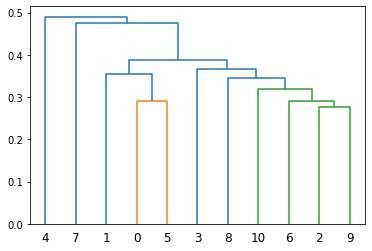

In [ ]:
allocation, linkage = get_allocations(x, True)
sch.dendrogram(linkage)

In [ ]:
data.columns

Index(['AAPL', 'AMZN', 'DDOG', 'FSLY', 'IBM', 'MSFT', 'NET', 'NFLX', 'PLTR',
       'SNOW', 'ZS'],
      dtype='object')

In [ ]:
allocation

,HRP,CLA
AAPL,0.084535,0.000000
AMZN,0.077889,0.000000
DDOG,0.018529,0.000000
FSLY,0.022070,0.000000
IBM,0.572966,0.876213
MSFT,0.087757,-0.023364
NET,0.019113,0.000000
NFLX,0.060517,0.080017
PLTR,0.020795,0.000000
SNOW,0.015892,0.000000


In [ ]:
capital_inicial = 1e6

In [ ]:
ganancia_mes_final

AAPL    1.110717
AMZN    1.178665
DDOG    1.027860
FSLY    1.261350
IBM     0.953141
MSFT    1.029003
NET     1.091711
NFLX    1.253332
PLTR    1.131250
SNOW    1.070726
ZS      1.119067
dtype: float64

In [ ]:
# ¿Que es este valor? - Como reparto mi capital
allocation.HRP*capital_inicial

AAPL     84535.425172
AMZN     77888.753390
DDOG     18529.074146
FSLY     22070.239627
IBM     572966.189107
MSFT     87756.701151
NET      19112.562169
NFLX     60517.262228
PLTR     20795.194279
SNOW     15891.934931
ZS       19936.663801
Name: HRP, dtype: float64

In [ ]:
# ¿Qué representa este número? Ganancia final despues de 1 mes
np.dot(allocation.HRP*capital_inicial, ganancia_mes_final)

1028566.9671923766

In [ ]:
# ¿Y este número? Ganancia final despues de un mes
np.dot(np.abs(allocation.CLA)*capital_inicial, ganancia_mes_final)

959483.5881775069

# Ejercicio:

Lo que se hizo fue obtener datos de un año. Los primero 11 meses se utilizan para el algoritmo y el último mes se reserva para probar efectividad del algoritmo.

AHORA, ustedes deben obtener un periodo de 2 años de información y van a:

- Utilizar el primer año para obtener los portafolios con los algoritmos HRP y CLA

- Obtener como cambiaría la inversión mes con mes, es decir: 
  - De los datos del segundo año tendremos 12 meses de datos.
  - Veamos como cambia la inversión de tiempo 0 final del mes 1 (30 dias despues o 20 periodos de trading)
  - Despues como cambia del tiempo 0 al final del mes 2 (60 días o aprox. 40 periodos de trading)
  - Despues como cambia del tiempo 0 al final del mes 3 (90 dias o aprox. 60 días de trading)
  - Continuar con ese proceso. lo que nos daria 12 valores para cada portafolio (2 vectores)

- Graficar dicho cambio en el tiempo

# Graficar Comparación

In [ ]:
import plotly.express as px

In [ ]:
# Graficar como avanza en el tiempo el ejercicio de arriba

#fig = px.line('', markers = True)  # cumsum
#fig.update_layout(hovermode = 'x')
#fig.show()

In [ ]:
# Como se comportan los activos en todo el periodo
px.line(data)